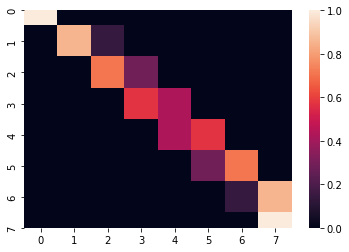

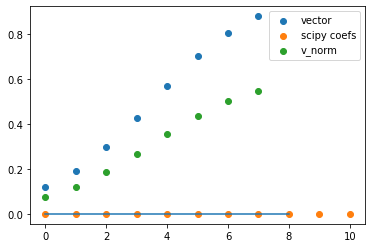

Condition number
 62.475138845718426
norm(yk) 1.603072812989229


In [6]:
from vqls import *
from utils import *
lower = 0.
upper = 1. 
n_step = 8
f_i = 0.0  
MAX_ITER = 200

nq=3
# K = 2^n = dim(T)-2
# with dim(S) = KxK
# n = num qubits
# T = set of knots

scaled=False

label = 'tanh'
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
  norm = np.linalg.norm(y)
  y = y / norm
tck=splrep(x,y,k=1) #coeffs
#plt.scatter(range(len(tck[1])),tck[0], label = "scipy knots")


#############################################################################################
###################################### System Preparation ###################################
#############################################################################################

matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled);

import seaborn as sns

sns.heatmap(matrix)
plt.show()
plt.plot(y)

plt.scatter(range(len(vector)), vector, label="vector")
plt.scatter(range(len(tck[1])),tck[1], label="scipy coefs")
plt.scatter(range(len(v_norm)), v_norm, label="v_norm")
plt.legend()
plt.show()
#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################

k_numb=np.linalg.cond(np.array(matrix))
print('Condition number\n',k_numb)
print('norm(yk)',np.linalg.norm(vector))




In [2]:
df = pd.read_json("results.json")
df

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,62.475139,1.77257,[0.25583961250000004],110.668217,"[[1.1766524858, 2.9867570807, 2.2996267901, 1....",3.332392,3.145764,42


## asbgn


In [7]:
import time
#weights = np.load("weights_8.npy")

74
Optimizing variational params..
Starting parameters = [2.56511305 3.13497876 1.03184872 0.32301965 0.61688515 2.95806846
 1.90626809 1.06409968 0.50846377]
Cost at Step 0: 0.4871483
Cost at Step 1: 0.4360101
Cost at Step 2: 0.4289676
Cost at Step 3: 0.4522227
Cost at Step 4: 0.4342692
Cost at Step 5: 0.4406894
Cost at Step 6: 0.2773366
Cost at Step 7: 0.2801123
Cost at Step 8: 0.2559416
Cost at Step 9: 0.1304983
Cost at Step 10: 0.2350130
Cost at Step 11: 0.2105394
Cost at Step 12: 0.1104530
Cost at Step 13: 0.1687108
Cost at Step 14: 0.1170907
Cost at Step 15: 0.0726484
Cost at Step 16: 0.0961559
Cost at Step 17: 0.1044068
Cost at Step 18: 0.0989980
Cost at Step 19: 0.0793476
Cost at Step 20: 0.0569888
Cost at Step 21: 0.0106693
Cost at Step 22: 0.0307345
Cost at Step 23: 0.0220778
Cost at Step 24: 0.0554225
Cost at Step 25: 0.0081869
Cost at Step 26: 0.0598760
Cost at Step 27: 0.0094735
Cost at Step 28: 0.0315588
Cost at Step 29: 0.0052019
Cost at Step 30: 0.0053164
Cost at Step 3

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


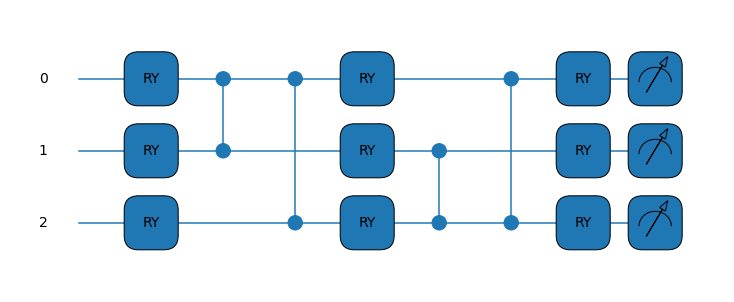

In [8]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

print('Optimizing variational params..')
start = time.time()
weights = vqls_circuit.train(max_iter=MAX_ITER)  
end = time.time()
print("The time of execution of above program is :", end-start)
q = vqls_circuit.solution(weights, True)
print('Quantum coefficients         :',q)
print("Variational Circuit's weights:",weights)


In [9]:

np.save(f"weights_{label}_{n_step}_{MAX_ITER}", weights)

(<Figure size 1000x400 with 1 Axes>, <Axes:>)


d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


tensor([ 0.7254213 +0.j, -0.44768298+0.j, -0.31295928+0.j,
         0.23484574+0.j, -0.2351908 +0.j,  0.18250717+0.j,
         0.15389057+0.j, -0.08911773+0.j], requires_grad=True)

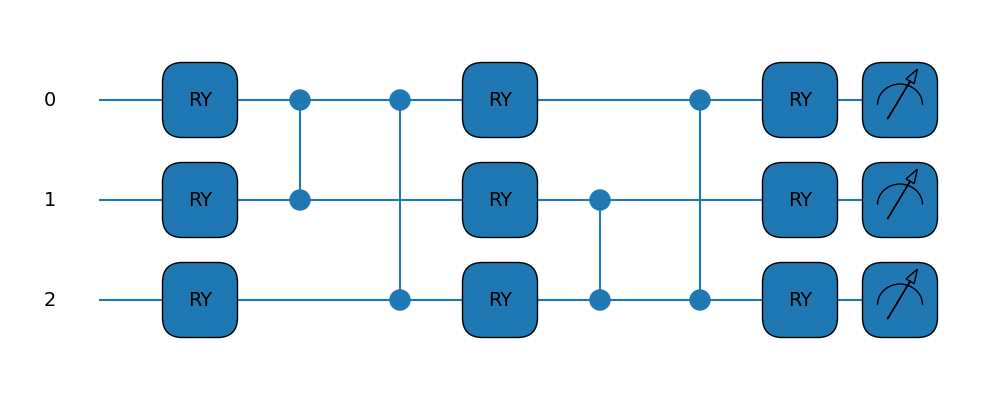

In [17]:
q = vqls_circuit.solution(weights, True)
q

## aosiegn


In [18]:
#Classic beta coefficients
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
print('beta  qunatum')
y_c=np.dot(matrix,c) #classic


y_q=np.dot(matrix,q) #hybrid
                     #Quantum
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))
rss_full = np.sum(np.square(np.array(y_c) - np.array(y_fq)))
rss_hybr = np.sum(np.square(np.array(y_c) - np.array(y_q)))

print('RSS_q:',rss_full)
print('RSS_h:',rss_hybr)



beta_classic                 : [ 0.11920292  0.24295564 -0.10448426  1.30398885 -0.73752719  1.55230194
  0.36196794  0.88079708]
beta  qunatum
RSS_q: 3.494316918821219
RSS_h: (3.4128797493317817+0j)


In [12]:
np.save(f"in_training_weight_{n_step}_{MAX_ITER}", vqls_circuit.testing_product)

In [19]:
y_train_fq = []
for i in range(len(vqls_circuit.testing_product)):
      y_fq = []
      for el in matrix:
            y_fq.append(vqls_circuit.direct_prod2(vqls_circuit.testing_product[i],el))
      y_train_fq.append(y_fq)

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,
d:\conda\envs\res\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


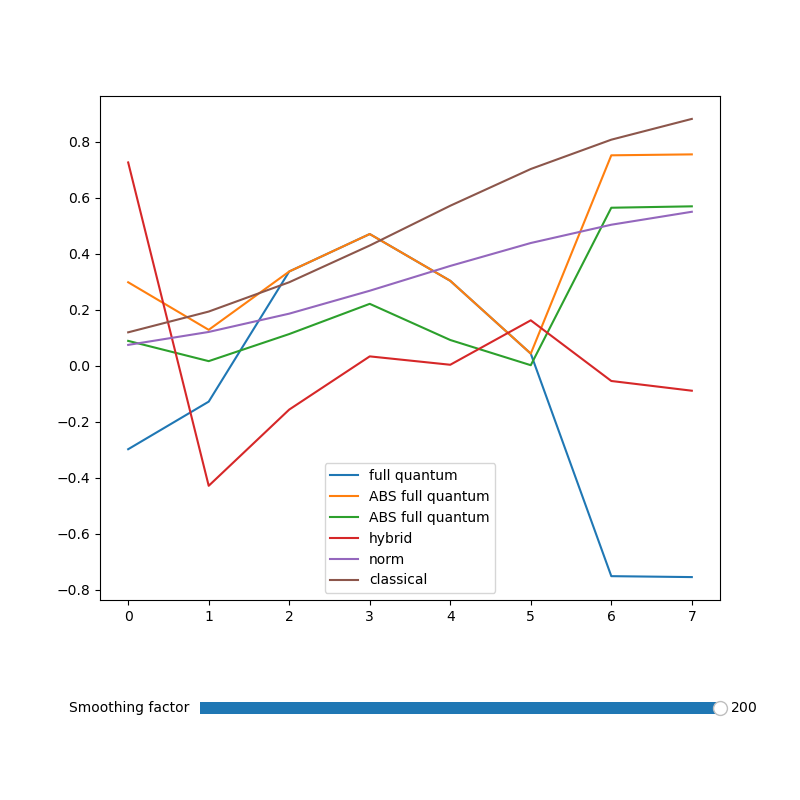

In [27]:
%matplotlib widget 
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
# Initial x and y arrays
# Spline interpolation
# Plotting
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(vqls_circuit.testing_product[0],el))

fig = plt.figure(figsize=[8,8])

plt.subplots_adjust(bottom=0.25)
ax = fig.subplots()
plt.legend()

p = ax.plot(range(len(y_fq)),y_fq, label= "full quantum")
h = ax.plot(range(len(y_fq)),np.abs(y_fq), label= "ABS full quantum")
b = ax.plot(range(len(y_fq)),np.power(y_fq,2), label= "ABS full quantum")

plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),v_norm,label= "norm")
plt.plot(range(len(y_fq)),y_c,label="classical")
plt.legend()

# Defining the Slider button
# xposition, yposition, width and height
ax_slide = plt.axes([0.25, 0.1, 0.65, 0.03])


# Properties of the slider
s_factor = Slider(ax_slide, 'Smoothing factor',
                1, len(vqls_circuit.testing_product)-1, valinit=len(vqls_circuit.testing_product)-1, valstep=1)

# Updating the plot
def update(val):
    current_v = s_factor.val
    p[0].set_ydata(y_train_fq[current_v])
    h[0].set_ydata(np.abs(y_train_fq[current_v]))
    b[0].set_ydata(np.power(y_train_fq[current_v],2))
    #redrawing the figure
    fig.canvas.draw()
    
# Calling the function "update" when the value of the slider is changed
s_factor.on_changed(update)
plt.show()

d:\conda\envs\res\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


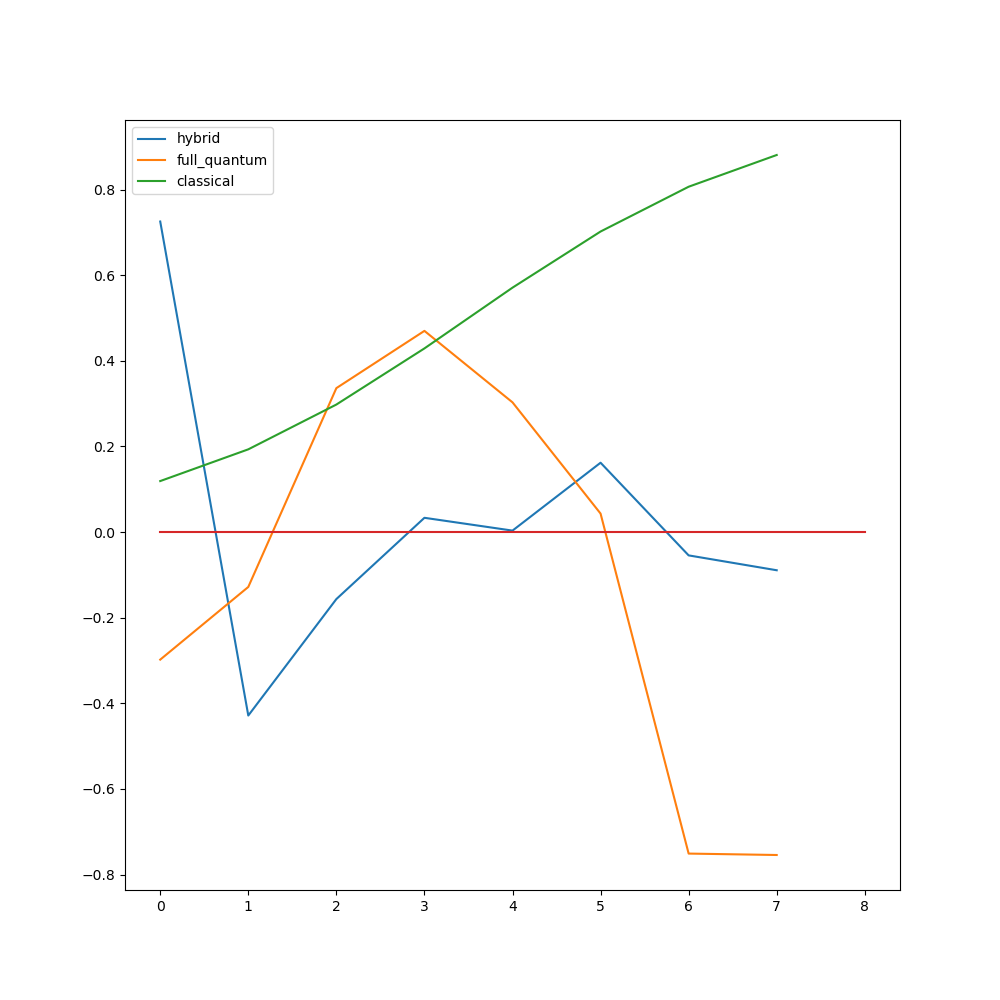

In [25]:
plt.figure(figsize=(10,10))
plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),y_fq, label="full_quantum")
plt.plot(range(len(y_fq)),y_c, label="classical")
plt.plot(y)
plt.legend()
plt.show()

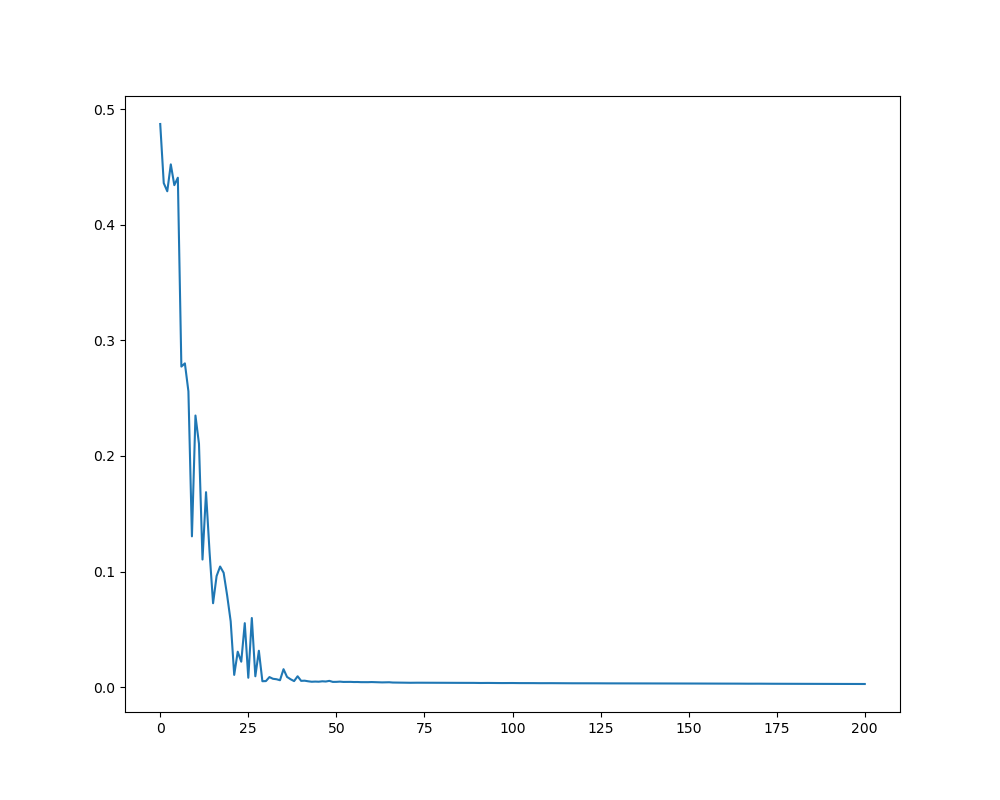

In [16]:
plt.figure(figsize=(10,8))
plt.plot(vqls_circuit.cost_vals);